## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.spatial.distance import cdist

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = "png"
np.random.seed(42)

In [2]:
train_df = pd.read_csv("course_project_train.csv")

In [3]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
train_df.shape

(7500, 17)

In [5]:
test_df = pd.read_csv("course_project_test.csv")

In [6]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [7]:
test_df.shape

(2500, 16)

In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Уменьшим размер данных в памяти и приведём их к единому типу

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

# EDA

* поиск и исправление выбросов
* поиск и заполнение пропусков
* идеи для генерации новых признаков

### Целевая переменная

In [12]:
y = train_df['Credit Default']
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [13]:
def display_clusters_distribution(df):
    unique = df.value_counts().index.tolist()
    counts = df.value_counts().values.tolist()
        
    """Визуализация распределения классов по кластерам"""
    #plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
def boxplot(df, y, feature):
    sns.set(rc={'figure.figsize':(20,10)})
    plt.xticks(rotation=45)
    sns.boxplot(df[feature], y)
    plt.show()
    plt.close()

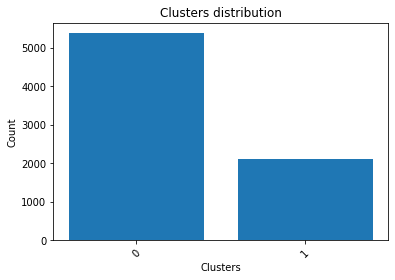

In [15]:
display_clusters_distribution(y)

### Целевая переменная несбалансирована, нужно будет попробовать расширить набор данных, например оверсемплингом

## Посмотрим категориальные данные

Признак: Home Ownership


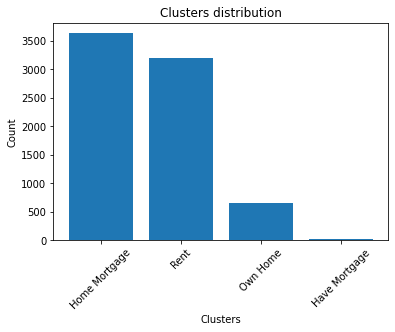

Признак: Years in current job


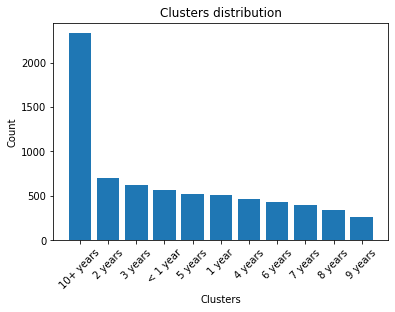

Признак: Purpose


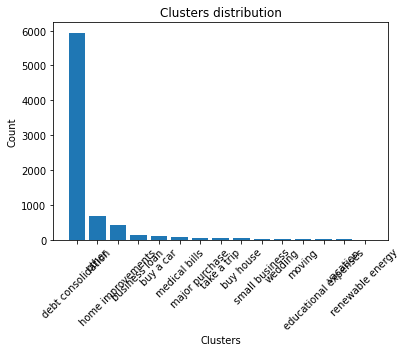

Признак: Term


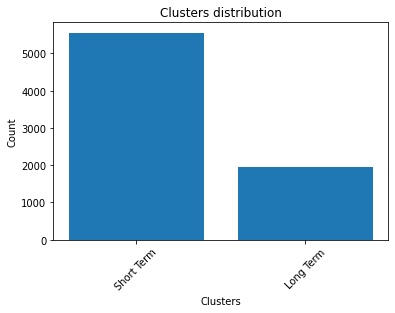

In [16]:
categories = train_df.select_dtypes(include="category").columns.tolist()
numerical = train_df.select_dtypes(exclude="category").columns.tolist()

for feature in categories:
    print(f"Признак: {feature}")
    display_clusters_distribution(train_df[feature])
    

### С признаками всё в порядке, один Purpose излишне несбалансирован, возможно стоит выразить его через свою численность

## Посмотрим числовые данные

In [17]:
def deviations(series):
  median = series.quantile(q=0.5)
  avg = series.mean()
  std = series.std()
  mode = series.mode()[0]
  print(f"Медиана со средним значением отличаются на {round(abs(median-avg)/std, 2):.02f} стандартных отклонения")
  if series.min() < median-std*3:
    print(f"Минимальное значение меньше, чем медиана - 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  if series.max() > median+std*3:
    print(f"Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  return median, avg, mode

In [18]:
def hist_plot(df, feature, median, avg, mode):
    #sns.set(rc={'figure.figsize':(20,10)})
    sns.distplot(df[feature])
    plt.axvline(median, c="red", label="median")
    plt.axvline(avg, c="green", label="average")
    plt.axvline(mode, c="orange", label="mode")
    plt.legend(loc="best", frameon=False)
    plt.title(feature)
    fig = plt.figure()
    #res = stats.probplot(df[feature], plot=plt)
    plt.show()
    plt.close()

Признак: Annual Income
count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64
1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


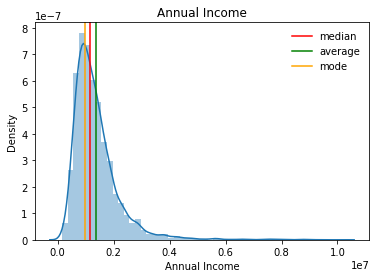

<Figure size 432x288 with 0 Axes>

Признак: Tax Liens
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
Медиана со средним значением отличаются на 0.11 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


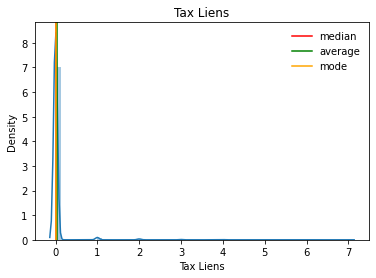

<Figure size 432x288 with 0 Axes>

Признак: Number of Open Accounts
count    7500.000000
mean       11.130934
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


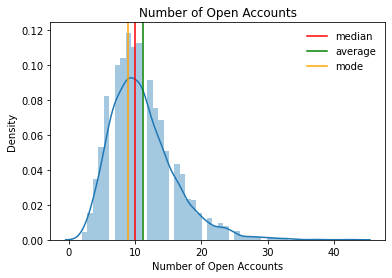

<Figure size 432x288 with 0 Axes>

Признак: Years of Credit History
count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.799999
max        57.700001
Name: Years of Credit History, dtype: float64
15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
44.000000      1
42.299999      1
36.700001      1
49.099998      1
44.799999      1
Name: Years of Credit History, Length: 408, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


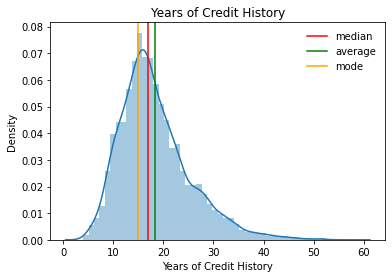

<Figure size 432x288 with 0 Axes>

Признак: Maximum Open Credit
count    7.500000e+03
mean     9.451538e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64
0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
235642.0      1
1435456.0     1
397078.0      1
537680.0      1
1516482.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64
Медиана со средним значением отличаются на 0.03 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


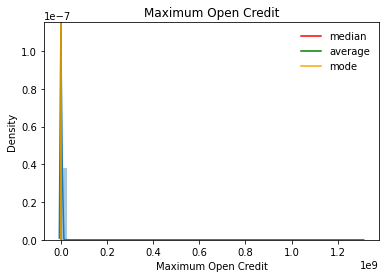

<Figure size 432x288 with 0 Axes>

Признак: Number of Credit Problems
count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


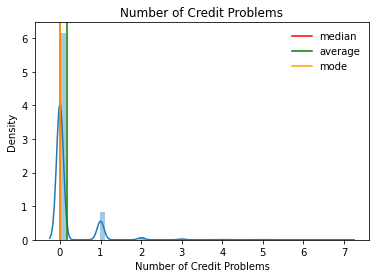

<Figure size 432x288 with 0 Axes>

Признак: Months since last delinquent
count    3419.000000
mean       34.692600
std        21.688807
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64
14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64
Медиана со средним значением отличаются на 0.12 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


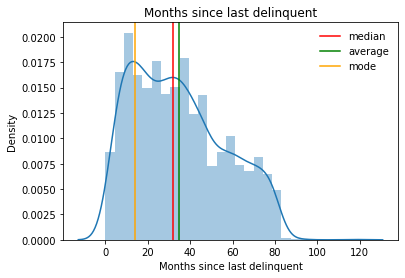

<Figure size 432x288 with 0 Axes>

Признак: Bankruptcies
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


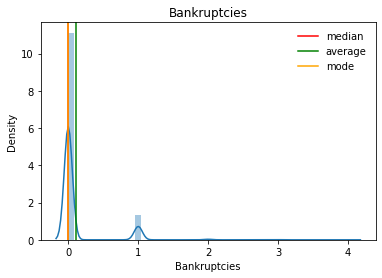

<Figure size 432x288 with 0 Axes>

Признак: Current Loan Amount
count         7500.0
mean      11873178.0
std       31926124.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64
100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64
Медиана со средним значением отличаются на 0.36 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


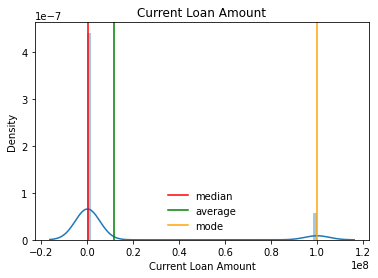

<Figure size 432x288 with 0 Axes>

Признак: Current Credit Balance
count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64
0.0         53
191710.0     5
106818.0     4
136401.0     4
82289.0      4
            ..
64733.0      1
66709.0      1
42199.0      1
871036.0     1
346902.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64
Медиана со средним значением отличаются на 0.25 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


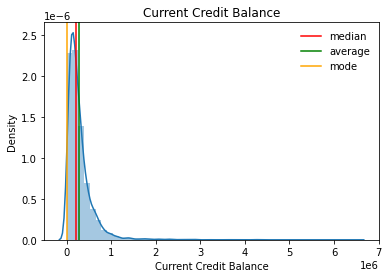

<Figure size 432x288 with 0 Axes>

Признак: Monthly Debt
count      7500.000000
mean      18314.453125
std       11926.764648
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64
0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


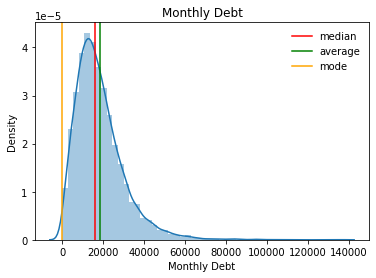

<Figure size 432x288 with 0 Axes>

Признак: Credit Score
count    5943.000000
mean     1151.087524
std      1604.451416
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64
740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64
Медиана со средним значением отличаются на 0.26 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


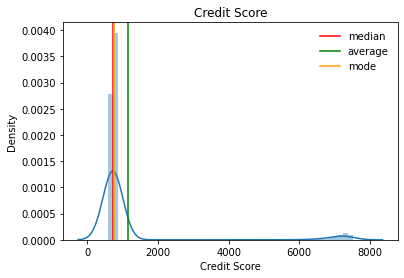

<Figure size 432x288 with 0 Axes>

Признак: Credit Default
count    7500.000000
mean        0.281733
std         0.449874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Credit Default, dtype: float64
0    5387
1    2113
Name: Credit Default, dtype: int64
Медиана со средним значением отличаются на 0.63 стандартных отклонения


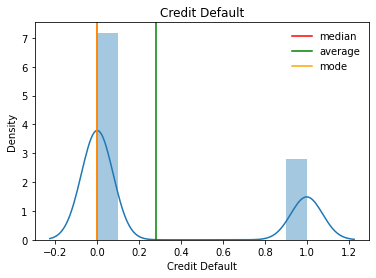

<Figure size 432x288 with 0 Axes>

In [19]:
for feature in numerical:
    print(f"Признак: {feature}")
    print(train_df[feature].describe())
    print(train_df[feature].value_counts())
    median, avg, mode = deviations(train_df[feature])
    hist_plot(train_df, feature, median, avg, mode)
    print("="*80)

### Выводы
* Большинству данных потребуется логарифмическая или ранговая нормализация
* Tax Liens, Number of Credit Problems, Bankruptcies - категориальные признаки (???)
* Очень не нравится в Current Loan Amount значение 100млн. Возможно, выброс.
* Maximum Open Credit, Current Credit Balance, Monthly Debt в 0 тоже маловероятен
* Credit Score максимальный 850, всё что больше нужно делить на 10.

In [20]:
class DataProcessor:
        
#     @staticmethod
#     def change_to_category(df):
#         # Переназначим категориальные признаки
#         suspected_categorials = ["Tax Liens"] # "Tax Liens", "Number of Credit Problems", "Bankruptcies", 
#         for col in suspected_categorials:
#             df[col] = df[col].astype("category")
#         return df
    
    @staticmethod
    def remove_outliers(df):
        # уберём выбросы
        df["Current Loan Amount"].loc[df["Current Loan Amount"] >= 99999999] = np.nan
        df["Maximum Open Credit"].loc[df["Maximum Open Credit"] == 0] = np.nan
        df["Current Credit Balance"].loc[df["Current Credit Balance"] == 0] = np.nan
        # df["Monthly Debt"].loc[df["Monthly Debt"] == 0] = np.nan
        df["Credit Score"].loc[df["Credit Score"] > 850] = df["Credit Score"].loc[df["Credit Score"] > 850]//10
        
        # удалим всё, выхоядщее за 3 квантиля
        for feature in df.select_dtypes(exclude="category").columns:
            if "tax" not in feature.lower():
                feature_median = df[feature].quantile(q=0.5)
                feature_std = df[feature].std()
                dist_max = feature_median + feature_std*3
                dist_min = feature_median - feature_std*3
                df[feature][(df[feature] > dist_max) | (df[feature] < dist_min)] = np.nan
        
        return df

    def fit(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)
        
        # вычислим моды
        self.modes = df.mode().loc[0]

        # подберём замену для пропусков по 10 соседям
        self.cols = df.select_dtypes(exclude="category").columns.to_list()
        self.imputer = KNNImputer(n_neighbors=10, weights="uniform", add_indicator=True)
        imputed = self.imputer.fit_transform(df[self.cols])
        cols_to_add = imputed.shape[1] - len(self.cols)
        self.cols.extend([f"Missing_{x}" for x in range(cols_to_add)])

    
    def transform(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)        
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)

        # выделим только категориальные данные
        categorical = df.select_dtypes(include="category")
        
        df["Months since last delinquent"].fillna(0, inplace=True)
        
        # автоматически заполним остальные пропуски
        imputed = self.imputer.transform(df.select_dtypes(exclude="category"))
        imputed = pd.DataFrame(imputed, columns=self.cols)
        for feature in imputed.columns:
            if "missing" in feature.lower():
                imputed[feature] = imputed[feature].astype("category")
        
        # заполним категориальные пропуски
        for feature in categorical.columns:
            if categorical[feature].isna().sum()>0:
                categorical[feature + '_nan'] = (categorical[feature].isna() * 1).astype("category")
                categorical[feature].fillna(self.modes.loc[feature], inplace=True)
        
        # вернём назад категориальные данные
        df = pd.concat([imputed, categorical], axis=1)
        
        return df


In [21]:
class FeatureGenerator:
    def fit(self, df, target):
        full_df = pd.concat([df,target], axis=1)
        self.purpose_count = df["Purpose"].value_counts().reset_index().rename(columns={"index":"Purpose", "Purpose":"PurposeCount"})
        self.yicj_def = full_df.groupby("Years in current job")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YICJ_proba"})
        self.purpose_def = full_df.groupby("Purpose")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_Purp_prob"})
        self.def_proba_per_problems = full_df.groupby("Number of Credit Problems")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOCP_prob"})
        self.tax_def = full_df.groupby("Tax Liens")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_TL_prob"})
        self.acc_def = full_df.groupby("Number of Open Accounts")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOA_prob"})
        self.delinquent_def = full_df.groupby("Months since last delinquent")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_del_prob"})
        self.bankr_def = full_df.groupby("Bankruptcies")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_bankr_prob"})    
        self.yoch_def = full_df.groupby("Years of Credit History")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YOCH_prob"})
        self.ho_def = full_df.groupby("Home Ownership")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_HO_prob"})
        self.cs_def = full_df.groupby("Credit Score")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_CS_prob"})
        self.term_def = full_df.groupby("Term")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_term_prob"})
        self.cs_nocp = full_df.groupby("Credit Score")["Number of Credit Problems"].agg("mean").reset_index().rename(columns={"Number of Credit Problems":"CS_NOCP"})
        
        self.scaler = MinMaxScaler()
        df_scaled = self.scaler.fit_transform(pd.get_dummies(df, drop_first=True).drop("Purpose_renewable energy", axis=1, errors="ignore"))
        self.kmeans = KMeans(n_clusters=13, random_state=42)
        self.kmeans.fit(df_scaled)
        
        
    def transform(self, df):
        df_scaled = self.scaler.transform(pd.get_dummies(df, drop_first=True).drop("Purpose_renewable energy", axis=1, errors="ignore"))
        kmeans_labels = pd.Series(self.kmeans.predict(df_scaled), name='clusters').astype("category")
        df = pd.concat([df, kmeans_labels], axis=1)
        
        # target encoding
        df = df.merge(self.purpose_count, on="Purpose", how="left")
        df = df.merge(self.purpose_def, on="Purpose", how="left")
        df = df.merge(self.yicj_def, on="Years in current job", how="left")
        df = df.merge(self.def_proba_per_problems, on="Number of Credit Problems", how="left")
        df = df.merge(self.tax_def, on="Tax Liens", how="left")
        df = df.merge(self.acc_def, on="Number of Open Accounts", how="left")
        df = df.merge(self.delinquent_def, on="Months since last delinquent", how="left")
        df = df.merge(self.bankr_def, on="Bankruptcies", how="left")
        df = df.merge(self.yoch_def, on="Years of Credit History", how="left")
        df = df.merge(self.ho_def, on="Home Ownership", how="left")
        df = df.merge(self.cs_def, on="Credit Score", how="left")
        df = df.merge(self.term_def, on="Term", how="left")
        df = df.merge(self.cs_nocp, on="Credit Score", how="left")
                
        
        # feature encoding
        df["Debt encumbrance"] = df["Monthly Debt"]/(df["Annual Income"]/12)
        df["Loan left"] = df["Current Loan Amount"]/df["Maximum Open Credit"]
        df["Credit left"] = df["Current Credit Balance"]/df["Maximum Open Credit"]
        df["Problems per credit"] = df["Number of Credit Problems"]/df["Maximum Open Credit"]
        df["Income per credit"] = df["Annual Income"]/df["Maximum Open Credit"]
        df["Problems per account"] = df["Number of Credit Problems"]/df["Number of Open Accounts"]
        
        # разобъём данные на квантили
        quantiles = 10
        for feature in df.columns:
            try:
                if df[feature].nunique() > 50:
                    #print(f"Working on {feature}, uniques = {df[feature].nunique()}")
                    df[feature + "_quant"] = pd.qcut(train_df[feature],
                                                  q=np.linspace(0, 1, quantiles+1), # (0, .25, .5, .75, 1.)
                                                  labels=range(quantiles), # (0, 1, 2, 3)
                                                  duplicates="drop").astype("category") 
            except KeyError:
                #print(f"{feature} raised KeyError!")
                continue
            except ValueError:
                #print(f"{feature} raised ValueError!")
                continue
        
        # если есть медианы - заполняем пропуски, нет - генерим медианы
        try:
            df.fillna(self.medians, inplace=True)
        except:
            self.medians = df.median()
        
        return df

In [22]:
y = train_df["Credit Default"]
train_df = train_df.drop("Credit Default", axis=1)

In [23]:
processor = DataProcessor()
processor.fit(train_df)
train_df = processor.transform(train_df)
test_df = processor.transform(test_df)

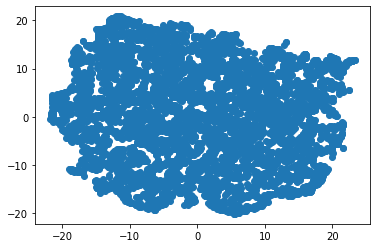

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, learning_rate=30, random_state=42, perplexity=30, n_iter=500)
X_train_tsne = tsne.fit_transform(pd.get_dummies(train_df))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:,1])

### Перепробовал массу вариантов с разными параметрами, ничего не видно...

In [25]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    X = pd.get_dummies(X, drop_first=True)
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

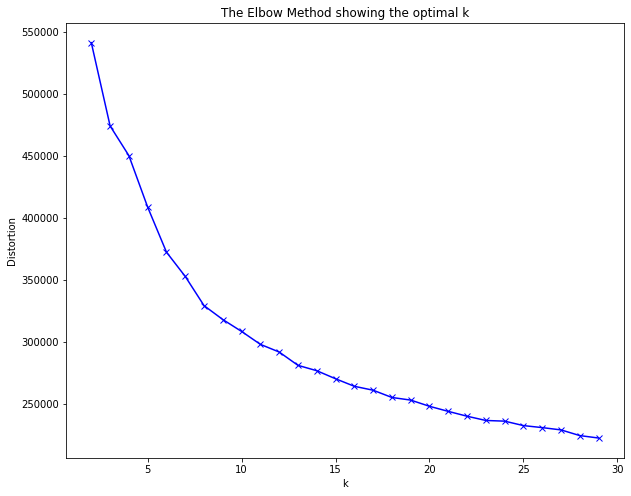

In [26]:
apply_elbow_method(train_df)

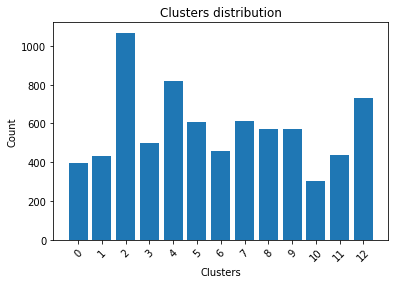

In [27]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(pd.get_dummies(train_df, drop_first=True))

kmeans = KMeans(n_clusters=13, random_state=42)
labels = kmeans.fit_predict(X_scaled)
labels = pd.Series(labels, name='clusters')

display_clusters_distribution(labels)

### Выглядит прилично, добавим в данные

### Проверим базовую модель

In [28]:
def fit_predict(df, y, scaler):
    train, test, y_train, y_test = train_test_split(pd.get_dummies(df, drop_first=True),
                                                    y,
                                                    test_size = 0.3,
                                                    shuffle=True,
                                                    stratify=y)

    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    lrcv = LogisticRegressionCV()
    lrcv.fit(train_scaled, y_train)
    y_pred = lrcv.predict(test_scaled)
    print('F1 score:', f1_score(y_test, y_pred))

In [29]:
fit_predict(train_df, y, scaler=MinMaxScaler())

F1 score: 0.23357664233576642


## Добавим новых признаков

In [30]:
feature_generator = FeatureGenerator()
feature_generator.fit(train_df, y)
train_df = feature_generator.transform(train_df)
test_df = feature_generator.transform(test_df)

In [31]:
fit_predict(train_df, y, scaler=MinMaxScaler())

F1 score: 0.4722222222222222


In [32]:
# проверим пропуски
print(f"Train NaNs: {train_df.isna().sum().sum()}")
print(f"Test Nans: {test_df.isna().sum().sum()}")

Train NaNs: 0
Test Nans: 0


In [33]:
def correlation_matrix(df):
    df = df.copy()
#     df = pd.get_dummies(df, drop_first=True)
    plt.figure(figsize=(20,20))
    sns.set(font_scale=0.8)
    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix)<0.3] = 0
    sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap="coolwarm")
    plt.title("Матрица корреляции")
    plt.plot()

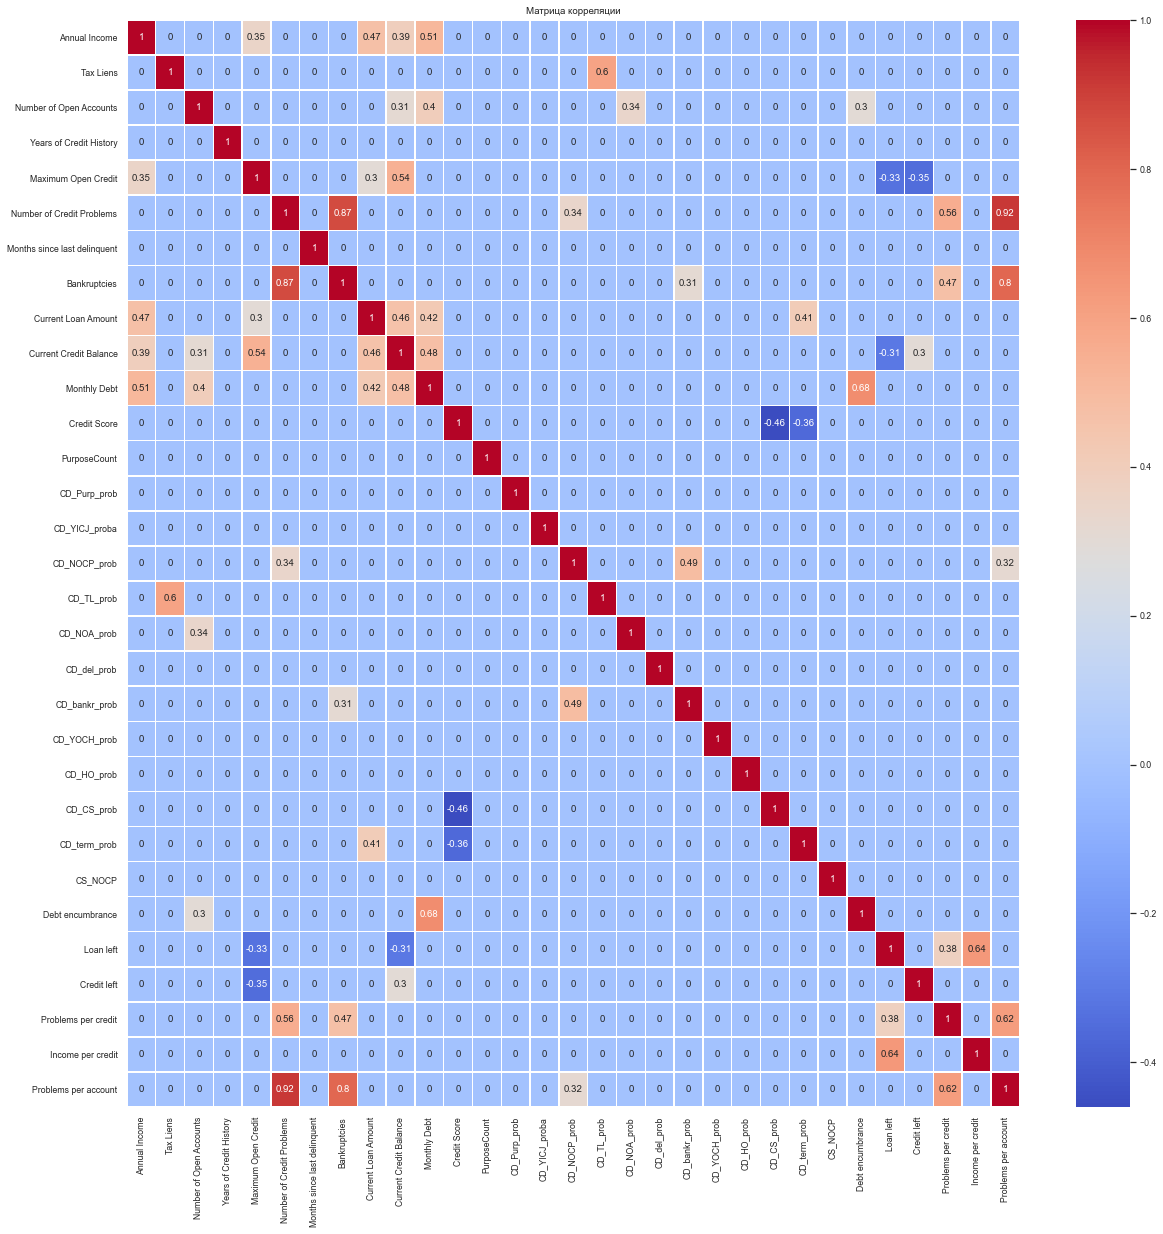

In [34]:
correlation_matrix(train_df)

### Выводы
Много кореллирующих данных, можно будет очень хорошо уменьшить размерность с помощью PCA

## Поскольку датасет несбалансирован, попробуем нагенерить синтетических данных

In [35]:
!pip install imblearn

distutils: c:\users\m0rtal\appdata\local\programs\python\python39\Include\UNKNOWN
sysconfig: c:\users\m0rtal\appdata\local\programs\python\python39\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\m0rtal\appdata\local\programs\python\python39\Include\UNKNOWN
sysconfig: c:\users\m0rtal\appdata\local\programs\python\python39\Include
user = False
home = None
root = None
prefix = None


In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [37]:
oversample = SMOTE(n_jobs=-1)
print(f"Original dataset shape: {train_df.shape}, {y.shape}")
X_res, y_res = oversample.fit_resample(pd.get_dummies(train_df, drop_first=True), y)
print(f"Resampled dataset shape: {X_res.shape}, {y_res.shape}")

Original dataset shape: (7500, 56), (7500,)
Resampled dataset shape: (10774, 154), (10774,)


In [38]:
fit_predict(X_res, y_res, scaler=MinMaxScaler())

F1 score: 0.8179124135660191


In [43]:
from scipy.stats import shapiro
for feature in X_res.columns:
    print(feature, shapiro(X_res[feature]))

Annual Income ShapiroResult(statistic=0.966394305229187, pvalue=2.942726775082116e-44)
Tax Liens ShapiroResult(statistic=0.1063535213470459, pvalue=0.0)
Number of Open Accounts ShapiroResult(statistic=0.978419303894043, pvalue=2.3522783446472624e-37)
Years of Credit History ShapiroResult(statistic=0.9750897288322449, pvalue=1.5877047912431615e-39)
Maximum Open Credit ShapiroResult(statistic=0.6917586326599121, pvalue=0.0)
Number of Credit Problems ShapiroResult(statistic=0.42279428243637085, pvalue=0.0)
Months since last delinquent ShapiroResult(statistic=0.7647247314453125, pvalue=0.0)
Bankruptcies ShapiroResult(statistic=0.37189263105392456, pvalue=0.0)
Current Loan Amount ShapiroResult(statistic=0.9476589560508728, pvalue=0.0)
Current Credit Balance ShapiroResult(statistic=0.9233736991882324, pvalue=0.0)
Monthly Debt ShapiroResult(statistic=0.9695190191268921, pvalue=1.0944141006376821e-42)
Credit Score ShapiroResult(statistic=0.9006062746047974, pvalue=0.0)
PurposeCount ShapiroResu